<a href="https://colab.research.google.com/github/leighd2008/TF-class-colab-notebooks/blob/main/05_Transfer_Learning_in_TensorFlow_Part2_Fine_tuning_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.
2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?
3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?
4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

## Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

In [ ]:
# Get helper_functions.py from my github account
!wget https://raw.githubusercontent.com/leighd2008/TF-class-colab-notebooks/main/helper_functions.py

--2022-07-03 14:39:34--  https://raw.githubusercontent.com/leighd2008/TF-class-colab-notebooks/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10735 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.48K  --.-KB/s    in 0s      

2022-07-03 14:39:34 (64.0 MB/s) - ‘helper_functions.py’ saved [10735/10735]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, \
  unzip_data, walk_through_dir

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-07-03 14:39:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.128, 142.250.98.128, 142.250.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   125MB/s    in 1.3s    

2022-07-03 14:39:45 (125 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Preprocess data
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. Pass inputs to base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 5. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 6. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 7. Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 8. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 9. Fit the model and save its history
history_model_0 = model_0.fit(train_data_10_percent,
                              epochs=10,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220703-143957
Epoch 1/10
24/24 [==============================] - 81s 3s/step - loss: 1.9267 - accuracy: 0.3680 - val_loss: 1.3856 - val_accuracy: 0.6875
Epoch 2/10
24/24 [==============================] - 79s 3s/step - loss: 1.1568 - accuracy: 0.7467 - val_loss: 0.9403 - val_accuracy: 0.7829
Epoch 3/10
24/24 [==============================] - 79s 3s/step - loss: 0.8313 - accuracy: 0.8280 - val_loss: 0.7668 - val_accuracy: 0.7977
Epoch 4/10
24/24 [==============================] - 80s 3s/step - loss: 0.6802 - accuracy: 0.8387 - val_loss: 0.6646 - val_accuracy: 0.8092
Epoch 5/10
24/24 [==============================] - 79s 3s/step - loss: 0.5851 - accuracy: 0.8640 - val_loss: 0.6255 - val_accuracy: 0.8207
Epoch 6/10
24/24 [=====

In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 131s 2s/step - loss: 0.4940 - accuracy: 0.8540


[0.49396562576293945, 0.8539999723434448]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

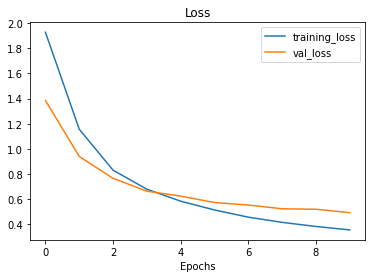

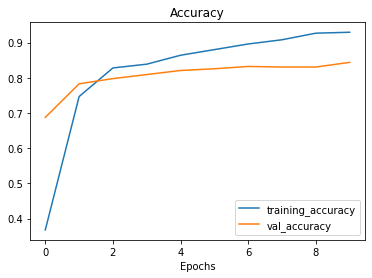

In [ ]:
# Look at model's training curves
plot_loss_curves(history_model_0)

## Model 1: feature extraction transfer learning model with 10% of data and data augmentation.

In [ ]:
# Create Model 1 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0 (include_top=False)
base_model.trainable=False

# Create the inputs and outputs
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="global_average_pooling2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2D (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)



## Fit model_1 using ModelCheckpoint callback

In [ ]:
# Fit the model, saving checkpoints every epoch
initial_epochs = 10
history_model_1 = model_1.fit(train_data_10_percent,
                              epochs=initial_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning_exercises",
                                                                     experiment_name="10_percent_data_aug"),
                                         checkpoint_callback])

Saving TensorBoard log files to: transfer_learning_exercises/10_percent_data_aug/20220703-145535
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 2.0136 - accuracy: 0.3160
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 92s 4s/step - loss: 2.0136 - accuracy: 0.3160 - val_loss: 1.4860 - val_accuracy: 0.6760
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.3683 - accuracy: 0.6560
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 84s 4s/step - loss: 1.3683 - accuracy: 0.6560 - val_loss: 1.0732 - val_accuracy: 0.7648
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.0742 - accuracy: 0.7547
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 86s 4s/step - loss: 1.0742 - accuracy: 0.7547 - val_loss: 0.8885 - val_accuracy: 0.78

In [ ]:
# Check model_1 results on all test data
results_10_percent_data_aug = model_1.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 135s 2s/step - loss: 0.5664 - accuracy: 0.8280


[0.5663753151893616, 0.828000009059906]

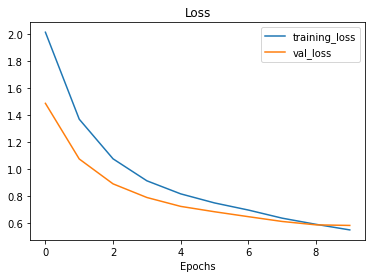

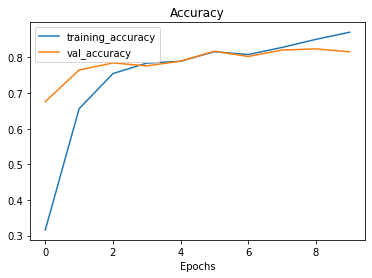

In [ ]:
# Plot model_1 loss curves
plot_loss_curves(history_model_1)

## Model_2: Fine-tuning an existing model (model_1) on 10% of the data

In [ ]:
# Layers in model_1
model_1.layers

In [ ]:
# None of our layers in model_1 are trainable
print(len(model_1.layers[2].trainable_variables))

0


In [ ]:
# Fine-tune the last 20 layers - first we need to set them to trainable
base_model.trainable = True

# Freeze all layers except the last 20
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Recompile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_1.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# How many trainable layers do we have
print(len(model_1.trainable_variables))

21


In [ ]:
# Fine tune for another 10 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model
history_model_2 = model_1.fit(train_data_10_percent,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              initial_epoch=history_model_1.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="model_2_fine_last_20")])

Saving TensorBoard log files to: transfer_learning/model_2_fine_last_20/20220703-151538
Epoch 10/20
24/24 [==============================] - 97s 4s/step - loss: 0.5220 - accuracy: 0.8547 - val_loss: 0.4911 - val_accuracy: 0.8421
Epoch 11/20
24/24 [==============================] - 87s 4s/step - loss: 0.4066 - accuracy: 0.8707 - val_loss: 0.5140 - val_accuracy: 0.8273
Epoch 12/20
24/24 [==============================] - 89s 4s/step - loss: 0.3329 - accuracy: 0.8947 - val_loss: 0.5105 - val_accuracy: 0.8454
Epoch 13/20
24/24 [==============================] - 85s 4s/step - loss: 0.3018 - accuracy: 0.9067 - val_loss: 0.5079 - val_accuracy: 0.8322
Epoch 14/20
24/24 [==============================] - 90s 4s/step - loss: 0.2482 - accuracy: 0.9267 - val_loss: 0.5463 - val_accuracy: 0.8273
Epoch 15/20
24/24 [==============================] - 87s 4s/step - loss: 0.2408 - accuracy: 0.9240 - val_loss: 0.4987 - val_accuracy: 0.8388
Epoch 16/20
24/24 [==============================] - 89s 4s/step -

In [ ]:
# Evaluate model 1 with 20 trainable layers
model_1.evaluate(test_data)

79/79 [==============================] - 134s 2s/step - loss: 0.5261 - accuracy: 0.8332


[0.5260865688323975, 0.8331999778747559]

In [ ]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History Objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")


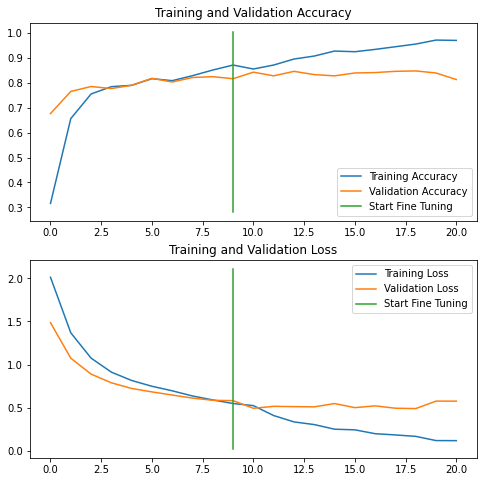

In [ ]:
import matplotlib.pyplot as plt

compare_histories(history_model_1, history_model_2, initial_epochs=10)

## Fine tune the last 30 layers of the base model (model_1) for another 10 epochs

In [ ]:
# Load in saved weights and evaluate model
model_1.load_weights(checkpoint_path)

In [ ]:
loaded_weights_model_results = model_1.evaluate(test_data)

79/79 [==============================] - 135s 2s/step - loss: 0.5664 - accuracy: 0.8280


In [ ]:
results_10_percent_data_aug

[0.5663753151893616, 0.828000009059906]

In [ ]:
loaded_weights_model_results

[0.5663753151893616, 0.828000009059906]

In [ ]:
# Set base_model trainable to true
base_model.trainable = True

# Freeze all but last 30 layers
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Recompile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])

In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_1.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Fine tune for another 10 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_2 except with more trainable layers)
history_model_3 = model_1.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_model_1.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="model_3_fine_last_30")])

Saving TensorBoard log files to: transfer_learning/model_3_fine_last_30/20220703-154007
Epoch 10/20
24/24 [==============================] - 101s 4s/step - loss: 0.5022 - accuracy: 0.8467 - val_loss: 0.5222 - val_accuracy: 0.8289
Epoch 11/20
24/24 [==============================] - 92s 4s/step - loss: 0.3901 - accuracy: 0.8800 - val_loss: 0.5030 - val_accuracy: 0.8355
Epoch 12/20
24/24 [==============================] - 94s 4s/step - loss: 0.3044 - accuracy: 0.9093 - val_loss: 0.5232 - val_accuracy: 0.8339
Epoch 13/20
24/24 [==============================] - 88s 4s/step - loss: 0.2833 - accuracy: 0.9147 - val_loss: 0.5300 - val_accuracy: 0.8273
Epoch 14/20
24/24 [==============================] - 78s 3s/step - loss: 0.2321 - accuracy: 0.9227 - val_loss: 0.4738 - val_accuracy: 0.8520
Epoch 15/20
24/24 [==============================] - 90s 4s/step - loss: 0.2085 - accuracy: 0.9400 - val_loss: 0.4983 - val_accuracy: 0.8438
Epoch 16/20
24/24 [==============================] - 93s 4s/step 

In [ ]:
results_model_3 = model_1.evaluate(test_data)

79/79 [==============================] - 124s 2s/step - loss: 0.5150 - accuracy: 0.8400


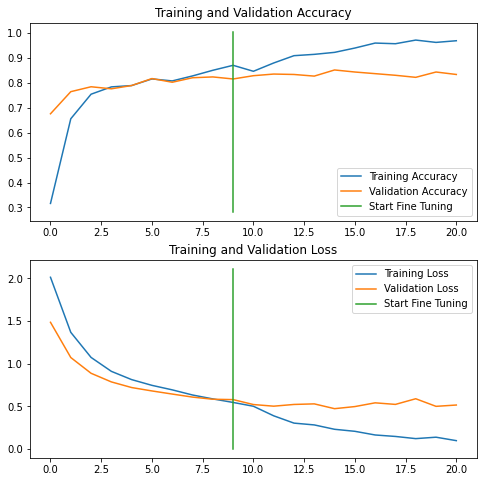

In [ ]:
compare_histories(history_model_1, history_model_3, initial_epochs=10)

## Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [ ]:
#from helper_functions import load_and_prep_image
# I'm just going to re-write it for practice
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into 
  (224, 224, 3).

  Parameters
  -----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224.
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (values between 0 and 1)
    return img/255
  else:
    return img

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

# Create a function to predict on images and plot them (multi-class)
def pred_and_plot_random_img(model, target_dir, class_names):
  """
  Imports an image located at filename, makes a prediction on it with a trained 
  model and plots the image with the predicted class as the title.
  
  Parameters
  -----------
  model (str): name of model to use for predictions
  target_dir (str): directory of images
  target_class (str): class for image
  class_name (str): list of class names
  """
  
  # Get a random class
  random_class = random.choice(class_names)
  # Set up the target directory
  target_folder = target_dir + random_class
  
  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  
  # Import the target image and preprocess it
  img = load_and_prep_image(target_folder + "/" + random_image[0], scale=False)
  #print(target_folder, "/" , random_image)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  #print(pred)

  # Get the predicted class
  if len(pred[0]) > 1:
    pred_class = class_names[pred.argmax()]
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])]

  img2 = mpimg.imread(target_folder + "/" + random_image[0])
  
  # plot the image and predicted class
  plt.imshow(img2)
  plt.title(f"Prediction: {pred_class} Actual: {random_class}")
  plt.axis(False);



In [ ]:
# Get class_names
import pathlib
import numpy as np
data_dir = pathlib.Path("10_food_classes_10_percent/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


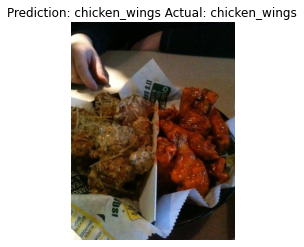

In [ ]:
pred_and_plot_random_img(model=model_1, 
                    target_dir="10_food_classes_10_percent/test/",
                    class_names=class_names)

## I did it the hard way, this is the way they did it

In [ ]:
# Creating a function to visualize an image from a dataset, visualize and give prediction

def dataset_visualizer(dataset, model):
  """
  Arguments:
    dataset --> `tf.data.Dataset` object with (image, label) tuples
    model --> the trained model
  
  Returns:
    visualize the image from the dataser and the predicted class of the image
  """
  image_batch, label_batch = dataset.as_numpy_iterator().next()
  batch_prob = [model.predict(tf.expand_dims(img, axis =0)) for img in image_batch]
  batch_preds = [class_names[np.argmax(prob)] for prob in batch_prob]

  plt.figure(figsize= (10, 10))
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    if class_names[np.argmax(label_batch[i])] == batch_preds[i]:
      title_color = 'g'
    else:
      title_color = 'r'
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f"actual: {class_names[np.argmax(label_batch[i])]}, pred: {batch_preds[i]}, prob: {batch_prob[i].max():.2f}", c = title_color)
    plt.axis('off')

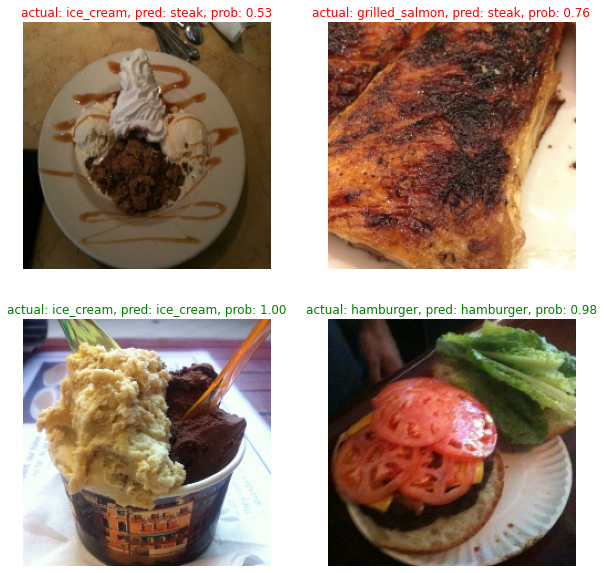

In [ ]:
dataset_visualizer(test_data, model_1)